# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import random
import re

from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor
import inspect

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('/kaggle/input/amazon-ml2024-100k-csvs/train_stratified.csv')
train_data.head()

,entity_name,kaggle_image_path,entity_value
0,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/61X...,180 gram
1,width,/kaggle/input/amazon-2024-100k-imgs/images/51f...,61.0 centimetre
2,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/416...,100.0 gram
3,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/61g...,360.0 gram
4,width,/kaggle/input/amazon-2024-100k-imgs/images/61A...,5.2 centimetre


In [3]:
test_data = pd.read_csv('/kaggle/input/amazon-ml2024-100k-csvs/test_stratified.csv')
test_data.head()

,entity_name,kaggle_image_path,entity_value
0,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/514...,20.0 gram
1,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/81k...,5.2 gram
2,item_weight,/kaggle/input/amazon-2024-100k-imgs/images/51T...,328.0 gram
3,depth,/kaggle/input/amazon-2024-100k-imgs/images/51r...,1.26 inch
4,height,/kaggle/input/amazon-2024-100k-imgs/images/51N...,40.0 centimetre


In [4]:
len(train_data), len(test_data), train_data['entity_name'].value_counts(), test_data['entity_name'].value_counts()

(80000,
 20000,
 entity_name
 item_weight                      31293
 depth                            13550
 width                            13368
 height                           13264
 voltage                           2883
 wattage                           2361
 item_volume                       2300
 maximum_weight_recommendation      981
 Name: count, dtype: int64,
 entity_name
 item_weight                      7823
 depth                            3388
 width                            3342
 height                           3316
 voltage                           721
 wattage                           590
 item_volume                       575
 maximum_weight_recommendation     245
 Name: count, dtype: int64)

# Experimenting - `google/pix2struct-docvqa-base`
## Inferencing as it is

In [5]:
model_1 = Pix2StructForConditionalGeneration.from_pretrained('google/pix2struct-docvqa-base')
processor_1 = Pix2StructProcessor.from_pretrained('google/pix2struct-docvqa-base')

config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [6]:
print("Model : ", inspect.signature(model_1.forward))
print("\nProcessor : ", inspect.signature(processor_1))

Model :  (flattened_patches: Optional[torch.FloatTensor] = None, attention_mask: Optional[torch.FloatTensor] = None, decoder_input_ids: Optional[torch.LongTensor] = None, decoder_attention_mask: Optional[torch.BoolTensor] = None, head_mask: Optional[torch.FloatTensor] = None, decoder_head_mask: Optional[torch.FloatTensor] = None, cross_attn_head_mask: Optional[torch.Tensor] = None, encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None, past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None, labels: Optional[torch.LongTensor] = None, decoder_inputs_embeds: Optional[torch.Tensor] = None, use_cache: Optional[bool] = None, output_attentions: Optional[bool] = None, output_hidden_states: Optional[bool] = None, return_dict: Optional[bool] = None) -> Union[Tuple[torch.FloatTensor], transformers.modeling_outputs.Seq2SeqModelOutput]

Processor :  (images=None, text: Union[str, List[str], List[List[str]]] = None, add_special_tokens: bool = True, padding: Union[bool, str, tr

In [7]:
# model and processor on sample image - inference
def random_predict(train_data, model, processor, n):
    if n>5:
        print("Too big. Setting n to 5.")
        n=5
    elif n<=0:
        print("Too small, setting n to 1.")
        n=1
    for i in range(n):
        random_number = random.randint(0, len(train_data)-1)
        
        image = Image.open(train_data['kaggle_image_path'][random_number])
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        
        text = f"What is the {train_data['entity_name'][random_number]} and its unit in this image?"
        inputs = processor(images=image, text=text, padding="max_length",
                           truncation=True, max_length=15, return_tensors="pt", add_special_tokens=False)
        ## ({'flattened_patches', 'attention_mask'})
        print("Inputs : ", inputs)
        print("Patches shape: ",inputs['flattened_patches'].shape)
        print("Attention Mask shape: ", inputs['attention_mask'].shape)
        
        label = processor.tokenizer.encode(train_data['entity_value'][random_number], 
                                                                     padding="max_length", truncation=True,
                                                                     max_length=15, return_tensors='pt')
        
        outputs = model(flattened_patches=inputs['flattened_patches'], attention_mask=inputs['attention_mask'], labels=label)
        print("Output with labels passed : ", outputs) #, outputs[0])
        print("Loss :", outputs.loss)
        print("----"*15)
        outputs = model.generate(**inputs)
        result = processor.decode(outputs[0], skip_special_tokens=True)
        print("Outputs for generate : ", outputs, outputs[0])
        print("Label Encoded as output form : ", label)
        print("Question : ", text)
        print("Result : ", result)
        print("Original : ", train_data['entity_value'][random_number])
        print("*"*50)

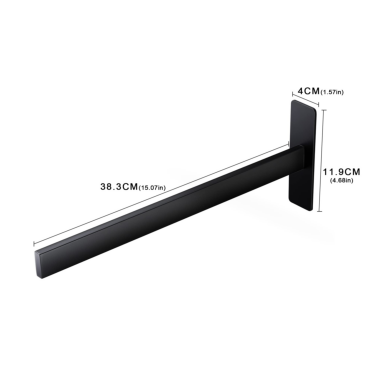

Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

Inputs :  {'flattened_patches': tensor([[[1.0000, 1.0000, 0.2994,  ..., 0.2994, 0.2994, 0.2994],
         [1.0000, 2.0000, 0.2994,  ..., 0.2958, 0.2958, 0.2958],
         [1.0000, 3.0000, 0.2994,  ..., 0.2994, 0.2994, 0.2994],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(21.4265, grad_fn=<NllLossBackward0>), logits=tensor([[[-54.8912, -13.0735, -55.3752,  ..., -29.3453, -31.2344, -25.6398],
         [-76.2079, -22.1258, -76.8204,  ..., -42.5418, -49.4923, -42.6435],
         [-64.3397, -15.2349, -64.9545,  ..., -39.9861, -41.4241, -40.8746],
         ...,
         [-55.6148, -12.9319, -56.0844,  ..., -30.1171, -33.4630, 

In [8]:
%%time
random_predict(train_data, model_1, processor_1, 1)

In [9]:
# The dataset is too noisy.
# The next iteration strategy would be data curation

-------

# Fine Tuning on our dataset

In [10]:
path = 'google/pix2struct-docvqa-base'
model = Pix2StructForConditionalGeneration.from_pretrained(path)
processor = Pix2StructProcessor.from_pretrained(path)

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    # torchvision.transforms.ToTensor(), # **BLUNDER** : Took me a week to understand my mistake! :(
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
# image = Image.open(train_data['kaggle_image_path'][42])
# image = transform(image)
# print(image.shape)
# plt.imshow(image.permute(1, 2, 0))
# plt.axis('off');

In [13]:
class VQADataset(nn.Module):
    def __init__(self, dataframe, processor, transform=False):
        super().__init__()
        self.data = dataframe
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['kaggle_image_path']
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
            
        text = f"What is the {self.data.iloc[idx]['entity_name']} and its unit in this image?"
        inputs = self.processor(images=image, text=text, padding="max_length",
                               truncation=True, max_length=15, return_tensors="pt", add_special_tokens=False)
        # print("Image shape :", image.shape) # PIL Image cannot be retured error.
        # print("Inputs :", inputs)
        # print("flattened_patches shape:", np.array(inputs['flattened_patches']).shape)
        # print("attention_mask shape:", np.array(inputs['attention_mask']).shape)

        label = self.data.iloc[idx]['entity_value']
        # print("Pre Label :", label)
        label = self.processor.tokenizer.encode(label, padding="max_length", truncation=True, 
                                         max_length=15, return_tensors='pt', return_attention_mask=False)
        
        # outputs = model(flattened_patches=inputs['flattened_patches'], attention_mask=inputs['attention_mask'], labels=label)
        # print("Label:", label)
        # print("Labels shape:", np.array(label).shape)
        # print("*"*100)
        # print(inputs['flattened_patches'].shape, inputs['attention_mask'].shape, label.shape)
        return (inputs['flattened_patches'], inputs['attention_mask'], label)

In [14]:
training_data = VQADataset(train_data.sample(frac=0.2), processor, transform)
testing_data = VQADataset(test_data, processor, transform)

In [15]:
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=1, shuffle=False)

In [16]:
next(iter(train_dataloader))[0]

tensor([[[[1.0000, 1.0000, 1.3295,  ..., 1.3295, 1.3295, 1.3295],
          [1.0000, 2.0000, 1.3295,  ..., 1.1194, 1.1194, 1.1194],
          [1.0000, 3.0000, 1.3295,  ..., 1.3295, 1.3295, 1.3295],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

In [17]:
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
epochs = 3    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
print(device)

cuda


In [18]:
from sklearn.metrics import f1_score
from torch.cuda.amp import autocast, GradScaler

# Initialize the GradScaler for mixed precision
scaler = GradScaler()

for epoch in range(epochs):
    epoch_loss = 0
    model.train()

    if epoch==2:
        for param in optimizer.param_groups:
            param['lr'] = 1e-6
            print(param['lr'])

    with tqdm(train_dataloader, desc=f"Training epoch {epoch+1}/{epochs}") as pbar:
        for batch in pbar:
            flattened_patches = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            # Use autocast to enable mixed precision
            with autocast():  # Automatic mixed precision for the forward pass
                outputs = model(flattened_patches=flattened_patches.squeeze(1), 
                                attention_mask=attention_mask.squeeze(1),
                                labels=labels.squeeze(1))
                loss = outputs.loss
                epoch_loss += loss.item()

            # Backpropagate with scaling for stability
            optimizer.zero_grad()
            scaler.scale(loss).backward()  # Scaled backward pass
            scaler.step(optimizer)         # Step with the scaler to update parameters
            scaler.update()                # Update the scaler for the next iteration

            pbar.set_postfix({"Running Loss": loss.item()})
        
    model.save_pretrained(f"Epoch-{epoch}-model")
    processor.save_pretrained(f"Epoch-{epoch}-processor")

Training epoch 2/3: 100%|██████████| 16000/16000 [3:16:00<00:00,  1.36it/s, Running Loss=0.0434]


1e-06


Training epoch 3/3: 100%|██████████| 16000/16000 [3:16:34<00:00,  1.36it/s, Running Loss=0.391]


In [19]:
 # with tqdm(test_dataloader, desc=f"Evaluating epoch {epoch+1}/{epochs}") as pbar:
    #     with torch.inference_mode(): 
    #         for batch in pbar:
    #             flattened_patches = batch[0].to(device)
    #             attention_mask = batch[1].to(device)
    #             labels = batch[2].to(device)

    #             outputs = model(
    #                 flattened_patches=flattened_patches.squeeze(0),
    #                 attention_mask=attention_mask.squeeze(0),
    #                 labels=labels.squeeze(0)
    #             )
                
    #             # Get predicted logits and labels
    #             loss = outputs.loss
    #             logits = outputs.logits
                
    #             epoch_loss += loss.item()

    #             # Convert logits to predicted labels
    #             preds = torch.argmax(logits, dim=-1).cpu().numpy()
    #             true_labels = labels.cpu().numpy()
                
    #             # Append predictions and true labels for F1 calculation
    #             epoch_preds.extend(preds)
    #             epoch_labels.extend(true_labels)
                
    #             # Update tqdm progress bar with the current loss
    #             pbar.set_postfix({"Loss": loss.item()})

    # avg_loss = epoch_loss / len(test_dataloader)
    
    # f1 = f1_score(epoch_labels, epoch_preds, average='weighted')  # You can change average type based on needs
    
    # print(f"Epoch {epoch+1}/{epochs} - Evaluation Loss: {avg_loss:.4f} | F1 Score: {f1:.4f}")

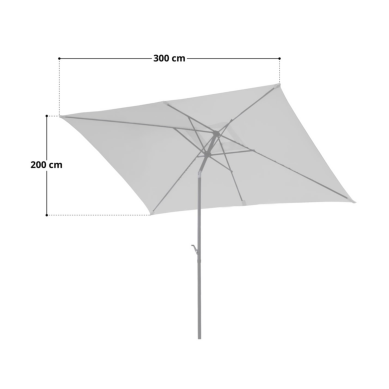

Inputs :  {'flattened_patches': tensor([[[1.0000, 1.0000, 0.3735,  ..., 0.3735, 0.3735, 0.3735],
         [1.0000, 2.0000, 0.3735,  ..., 0.3542, 0.3542, 0.3542],
         [1.0000, 3.0000, 0.3735,  ..., 0.3735, 0.3735, 0.3735],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(0.0022, grad_fn=<NllLossBackward0>), logits=tensor([[[-40.0368,  -7.8060, -36.3620,  ..., -24.0647, -21.4052, -19.5918],
         [-31.9532,  -9.2091, -27.9294,  ..., -19.0560, -17.4490, -20.8582],
         [-36.3171,  -8.8096, -32.1617,  ..., -22.4154, -23.6013, -27.5956],
         ...,
         [105.3329,  25.2340,  84.3451,  ...,  56.4206,  63.5640,  

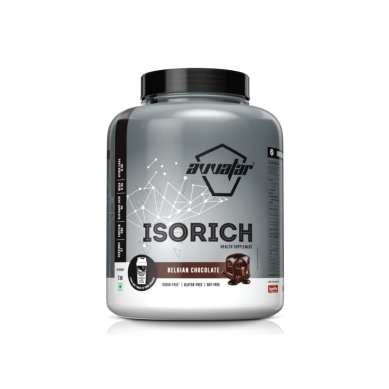

Inputs :  {'flattened_patches': tensor([[[ 1.0000,  1.0000,  0.5403,  ..., -1.3770, -1.3770, -1.3770],
         [ 1.0000,  2.0000,  0.5403,  ..., -1.1707, -1.1707, -1.1707],
         [ 1.0000,  3.0000,  0.5403,  ...,  0.5403,  0.5403,  0.5403],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(0.2813, grad_fn=<NllLossBackward0>), logits=tensor([[[-28.3888,  -7.0285, -26.4217,  ..., -16.7540, -18.1141, -13.3799],
         [-28.2430,  -7.8269, -25.0253,  ..., -17.6568, -18.6237, -16.8932],
         [-24.6967,  -4.6297, -22.4773,  ..., -14.3220, -13.5209, -15.0753],
         ...,
         [ 98.6229,  25.7446,  

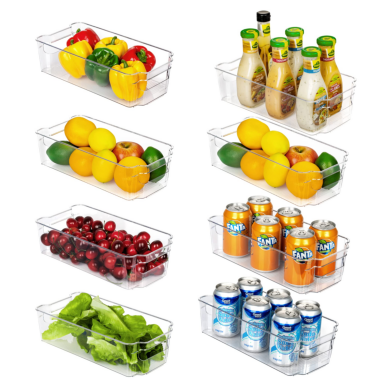

Inputs :  {'flattened_patches': tensor([[[ 1.0000,  1.0000,  0.6224,  ..., -1.6050, -1.6050, -1.6050],
         [ 1.0000,  2.0000,  0.6224,  ...,  0.1621,  0.1621,  0.1621],
         [ 1.0000,  3.0000,  0.6224,  ...,  0.6224,  0.6224,  0.6224],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(0.5521, grad_fn=<NllLossBackward0>), logits=tensor([[[-22.0166,  -4.9039, -20.8142,  ..., -16.2938, -14.4237, -10.6682],
         [-26.4727,  -6.3648, -23.7464,  ..., -19.3548, -18.3422, -16.2382],
         [-23.4655,  -4.0492, -21.5148,  ..., -15.2194, -13.2620, -13.3918],
         ...,
         [102.0625,  27.5648,  

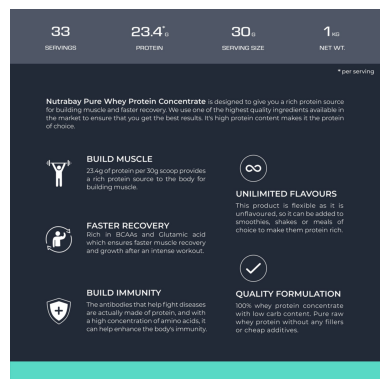

Inputs :  {'flattened_patches': tensor([[[1.0000, 1.0000, 2.8922,  ..., 1.0392, 1.0392, 1.0392],
         [1.0000, 2.0000, 2.8922,  ..., 1.0461, 1.0461, 1.0461],
         [1.0000, 3.0000, 2.8922,  ..., 2.8922, 2.8922, 2.8922],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(0.1211, grad_fn=<NllLossBackward0>), logits=tensor([[[-33.2005,  -9.0608, -30.9997,  ..., -23.0313, -22.2070, -14.8001],
         [-30.4771,  -6.9844, -26.8953,  ..., -18.1879, -19.0481, -16.0442],
         [-26.6582,  -1.6824, -24.4638,  ..., -16.0861, -15.9512, -18.1027],
         ...,
         [ 91.3142,  26.0882,  71.8153,  ...,  47.9408,  52.0399,  

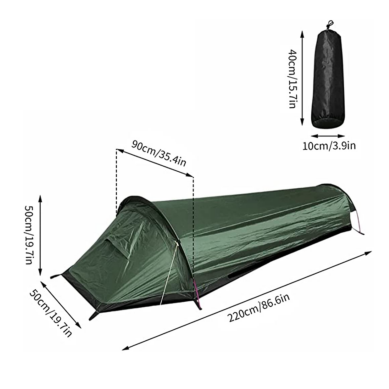

Inputs :  {'flattened_patches': tensor([[[1.0000, 1.0000, 0.4974,  ..., 0.4974, 0.4974, 0.4974],
         [1.0000, 2.0000, 0.4974,  ..., 0.4974, 0.4974, 0.4974],
         [1.0000, 3.0000, 0.4974,  ..., 0.4974, 0.4974, 0.4974],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}
Patches shape:  torch.Size([1, 2048, 770])
Attention Mask shape:  torch.Size([1, 2048])
Output with labels passed :  Seq2SeqLMOutput(loss=tensor(0.4093, grad_fn=<NllLossBackward0>), logits=tensor([[[-34.7338,  -8.9794, -31.4726,  ..., -19.1693, -19.0398, -18.1438],
         [-33.2610, -10.2074, -29.4239,  ..., -20.9093, -20.8219, -20.9975],
         [-29.4986,  -9.4750, -26.7431,  ..., -16.7452, -18.2565, -18.9515],
         ...,
         [ 96.3182,  22.6837,  76.2077,  ...,  53.2038,  53.4378,  

In [20]:
random_predict(train_data, model.to("cpu"), processor, 5)

---------

In [21]:
import torch

# Example encoding dictionary with batch dimension
encoding = {
    "pixel_values": torch.randn(1, 3, 224, 224),  # Shape (1, 3, 224, 224)
    "input_ids": torch.tensor([[101, 2054, 2003, 102]]),  # Shape (1, 4)
    "attention_mask": torch.tensor([[1, 1, 1, 1]])  # Shape (1, 4)
}

# Remove the batch dimension
print({k: v.shape for k, v in encoding.items()})
encoding = {k: v.squeeze(0) for k, v in encoding.items()}

print({k: v.shape for k, v in encoding.items()})

{'pixel_values': torch.Size([1, 3, 224, 224]), 'input_ids': torch.Size([1, 4]), 'attention_mask': torch.Size([1, 4])}
{'pixel_values': torch.Size([3, 224, 224]), 'input_ids': torch.Size([4]), 'attention_mask': torch.Size([4])}


In [22]:
processor_1.tokenizer("120 kilogram", padding="max_length", truncation=True, max_length=15, split_special_tokens=True)

{'input_ids': [273, 277, 279, 278, 37154, 19743, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}

In [23]:
inputs = processor_1(images=torch.rand(size=(3, 224, 224)), text="Sup", 
                padding='max_length', truncation=True, max_length=15)
inputs

{'flattened_patches': [array([[ 1.        ,  1.        ,  1.0312618 , ...,  0.5284742 ,
        -0.24558586, -0.5234234 ],
       [ 1.        ,  2.        ,  1.0312618 , ...,  0.57453096,
         0.04517085,  0.2339511 ],
       [ 1.        ,  3.        ,  1.0312618 , ...,  0.6851243 ,
         0.31489345,  0.07441761],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)], 'attention_mask': [array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)]}

In [24]:
print(model.config)

Pix2StructConfig {
  "_name_or_path": "google/pix2struct-docvqa-base",
  "architectures": [
    "Pix2StructForConditionalGeneration"
  ],
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "is_encoder_decoder": true,
  "is_vqa": false,
  "model_type": "pix2struct",
  "pad_token_id": 0,
  "text_config": {
    "encoder_hidden_size": 768,
    "initializer_range": 0.02,
    "model_type": "pix2struct_text_model"
  },
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.44.2",
  "vision_config": {
    "initializer_range": 0.02,
    "layer_norm_bias": false,
    "model_type": "pix2struct_vision_model",
    "num_channels": 3,
    "patch_size": 16,
    "projection_dim": 768
  }
}

